# Installation Instructions

Before running this notebook, please install the following dependencies:

## 1. Python Packages

Install required Python packages using pip:

```bash
pip install pyodbc pandas azure-identity
```

## 2. ODBC Driver 18 for SQL Server

### macOS (using Homebrew):
```bash
brew tap microsoft/mssql-release https://github.com/Microsoft/homebrew-mssql-release
brew update
brew install msodbcsql18
```

**Note:** You may need to install `unixodbc` first if you encounter library errors:
```bash
brew install unixodbc
```

### Windows:
1. Download the ODBC Driver 18 for SQL Server from: https://aka.ms/downloadmsodbcsql
2. Run the installer and follow the setup wizard
3. Alternatively, you can use `choco` (if Chocolatey is installed):
   ```powershell
   choco install msodbcsql18
   ```

### Linux (Ubuntu/Debian):
```bash
curl https://packages.microsoft.com/keys/microsoft.asc | apt-key add -
curl https://packages.microsoft.com/config/ubuntu/$(lsb_release -rs)/prod.list > /etc/apt/sources.list.d/mssql-release.list
apt-get update
ACCEPT_EULA=Y apt-get install -y msodbcsql18
```

## 3. Azure CLI (for Authentication)

The notebook uses Azure CLI for authentication. Install and login:

### macOS:
```bash
brew install azure-cli
az login
```

### Windows:
1. Download Azure CLI from: https://aka.ms/installazurecliwindows
2. Run the installer
3. Open PowerShell or Command Prompt and run:
   ```powershell
   az login
   ```

### Linux:
```bash
curl -sL https://aka.ms/InstallAzureCLIDeb | sudo bash
az login
```



## 4. Verify Installation

After installation, verify everything is set up correctly:

```python
# Test imports
import pyodbc
import pandas as pd
from azure.identity import AzureCliCredential

# Test Azure CLI login
import subprocess
result = subprocess.run(['az', 'account', 'show'], capture_output=True, text=True)
if result.returncode == 0:
    print("✓ Azure CLI is logged in")
else:
    print("✗ Please run 'az login' first")
```

## Troubleshooting

- **ODBC Driver not found**: Make sure ODBC Driver 18 is installed and the path is correct
- **Authentication errors**: Ensure you're logged into Azure CLI with `az login`
- **Permission errors**: Contact your administrator to ensure your Azure AD account has access to the database


In [4]:
# Microsoft Fabric SQL Analytics Connection
# Uses Azure AD token-based authentication (works in notebook environments)


import pyodbc
import pandas as pd

try:
    from azure.identity import (
        DeviceCodeCredential, 
        DefaultAzureCredential,
        AzureCliCredential
    )
    import struct
    from itertools import chain, repeat
    AZURE_IDENTITY_AVAILABLE = True
except ImportError:
    AZURE_IDENTITY_AVAILABLE = False
    print("⚠️  azure-identity not installed. Install with: pip install azure-identity")

def connect_to_fabric_sql(server: str, database_name: str, timeout: int = 60, use_token_auth: bool = False):
    """
    Connect to Microsoft Fabric SQL Analytics endpoint using Azure AD authentication.
    
    Args:
        server: Full server endpoint (e.g., 'workspace-id.datawarehouse.fabric.microsoft.com')
        database_name: The database name in your SQL Analytics endpoint
        timeout: Connection timeout in seconds (default: 60)
        use_token_auth: If True, use token-based authentication (recommended for notebooks)
    
    Returns:
        pyodbc.Connection object
    """
    print(f"Connecting to {server}...")
    
    # Method 1: Microsoft Entra ID token-based authentication (recommended for notebooks)
    if use_token_auth and AZURE_IDENTITY_AVAILABLE:
        print("Using Microsoft Entra ID token-based authentication...")
        
        # Try different scopes/resources for Fabric SQL Analytics
        # Fabric endpoints may require specific scopes
        scopes_to_try = [
            "https://database.windows.net//.default",  # Double slash format (works for Fabric)
            "https://database.windows.net/.default",  # Standard SQL Database scope
            "https://analysis.windows.net/powerbi/api/.default",  # Power BI/Fabric scope
        ]
        
        # Try different credential types in order of preference
        # AzureCliCredential is most reliable if Azure CLI is logged in
        credential_types = [
            ("AzureCliCredential", lambda: AzureCliCredential()),
            ("DefaultAzureCredential", lambda: DefaultAzureCredential()),
            ("DeviceCodeCredential", lambda: DeviceCodeCredential()),
        ]
        
        token = None
        used_scope = None
        used_credential_type = None
        
        for cred_name, cred_factory in credential_types:
            try:
                print(f"Trying {cred_name}...")
                credential = cred_factory()
                
                for scope in scopes_to_try:
                    try:
                        print(f"  Attempting with scope: {scope}")
                        token_response = credential.get_token(scope)
                        token = token_response.token
                        used_scope = scope
                        used_credential_type = cred_name
                        print(f"  ✓ Token obtained using {cred_name} with scope: {scope}")
                        break
                    except Exception as e:
                        print(f"  ✗ Failed with scope {scope}: {e}")
                        continue
                
                if token:
                    break
            except Exception as e:
                print(f"  ✗ {cred_name} failed: {e}")
                continue
        
        if token:
            try:
                print(f"Connecting using token from {used_credential_type}...")
                # Connection string without Authentication parameter (using token instead)
                # Note: Adding port 1433 explicitly (some Fabric endpoints may need this)
                conn_str = (
                    f"DRIVER={{ODBC Driver 18 for SQL Server}};"
                    f"SERVER={server},1433;"
                    f"DATABASE={database_name};"
                    f"Encrypt=yes;"
                    f"TrustServerCertificate=no;"
                    f"Connection Timeout={timeout};"
                    f"Login Timeout={timeout};"
                )
                
                # Encode token for ODBC - proper UTF-16-LE encoding with length prefix
                # This matches the format expected by ODBC Driver 18
                token_bytes = bytes(token, "UTF-8")
                # Interleave token bytes with zeros to create UTF-16-LE encoding
                encoded_bytes = bytes(chain.from_iterable(zip(token_bytes, repeat(0))))
                # Prepend length as little-endian integer
                token_struct = struct.pack("<i", len(encoded_bytes)) + encoded_bytes
                
                # Attribute 1256 is SQL_COPT_SS_ACCESS_TOKEN
                attrs_before = {1256: token_struct}
                conn = pyodbc.connect(conn_str, attrs_before=attrs_before)
                print(f"✓ Connected successfully using Microsoft Entra ID token ({used_credential_type})!")
                return conn
            except pyodbc.Error as e:
                error_str = str(e)
                if "18456" in error_str:
                    print(f"✗ Authentication failed (18456) - token may not have correct permissions.")
                    print(f"  Used scope: {used_scope}")
                    print(f"  This usually means:")
                    print(f"    1. Your Microsoft Entra ID account needs to be added as a user to the database")
                    print(f"    2. The database name '{database_name}' might be incorrect")
                    print(f"    3. You may need different permissions/scopes")
                else:
                    print(f"✗ Connection failed: {e}")
            except Exception as e:
                print(f"✗ Connection failed: {e}")
        else:
            print("✗ Could not obtain token from any credential type")
        
        print("Falling back to ODBC authentication methods...")
    
    # Method 2: ODBC authentication methods
    print("Trying ODBC authentication methods...")
    
    # Check if Azure CLI is available
    import subprocess
    az_cli_available = False
    try:
        result = subprocess.run(['az', 'account', 'show'], 
                              capture_output=True, 
                              timeout=2)
        az_cli_available = (result.returncode == 0)
    except (subprocess.TimeoutExpired, FileNotFoundError):
        az_cli_available = False
    
    # Try Azure CLI token-based authentication first (most reliable if Azure CLI is logged in)
    if az_cli_available:
        try:
            print("Getting access token from Azure CLI...")
            import json
            
            # Try different resources for Fabric endpoints
            # Double slash format works best for Fabric SQL Analytics
            resources_to_try = [
                'https://database.windows.net//.default',  # Double slash format (works for Fabric)
                'https://database.windows.net/.default',  # Standard format
                'https://database.windows.net/',  # Without .default
                'https://analysis.windows.net/powerbi/api/.default'  # Power BI/Fabric scope
            ]
            
            token = None
            for resource in resources_to_try:
                try:
                    result = subprocess.run(
                        ['az', 'account', 'get-access-token', '--resource', resource, '--output', 'json'],
                        capture_output=True,
                        text=True,
                        timeout=10
                    )
                    if result.returncode == 0:
                        token_data = json.loads(result.stdout)
                        token = token_data.get('accessToken')
                        if token:
                            print(f"Got token using resource: {resource}")
                            break
                except Exception as e:
                    continue
            
            if token:
                print("Using Azure CLI token for authentication...")
                # Connection string without Authentication parameter (using token instead)
                # Note: Adding port 1433 explicitly (some Fabric endpoints may need this)
                conn_str = (
                    f"DRIVER={{ODBC Driver 18 for SQL Server}};"
                    f"SERVER={server},1433;"
                    f"DATABASE={database_name};"
                    f"Encrypt=yes;"
                    f"TrustServerCertificate=no;"
                    f"Connection Timeout={timeout};"
                    f"Login Timeout={timeout};"
                )
                
                # Encode token for ODBC - proper UTF-16-LE encoding with length prefix
                token_bytes = bytes(token, "UTF-8")
                # Interleave token bytes with zeros to create UTF-16-LE encoding
                encoded_bytes = bytes(chain.from_iterable(zip(token_bytes, repeat(0))))
                # Prepend length as little-endian integer
                token_struct = struct.pack("<i", len(encoded_bytes)) + encoded_bytes
                
                # Attribute 1256 is SQL_COPT_SS_ACCESS_TOKEN
                attrs_before = {1256: token_struct}
                conn = pyodbc.connect(conn_str, attrs_before=attrs_before)
                print("✓ Connected successfully using Azure CLI token!")
                return conn
            else:
                print("No access token found from Azure CLI")
        except pyodbc.Error as e:
            error_str = str(e)
            if "18456" in error_str or "authentication failed" in error_str.lower():
                print(f"Authentication failed - token may not have correct permissions for this database.")
                print(f"Error: {e}")
                print("This might mean:")
                print("  - You don't have access to this database")
                print("  - The token needs different permissions/scopes")
                print("  - Try using token authentication with DeviceCodeCredential instead")
            else:
                print(f"Azure CLI token authentication failed: {e}")
        except Exception as e:
            print(f"Azure CLI token authentication failed: {e}")
        print("Falling back to other methods...")
    
    # Fallback: Try ActiveDirectoryInteractive (browser authentication)
    conn_str_interactive = (
        f"DRIVER={{ODBC Driver 18 for SQL Server}};"
        f"SERVER={server};"
        f"DATABASE={database_name};"
        f"Authentication=ActiveDirectoryInteractive;"
        f"Encrypt=yes;"
        f"TrustServerCertificate=no;"
        f"Connection Timeout={timeout};"
        f"Login Timeout={timeout};"
    )
    
    try:
        print("Trying ActiveDirectoryInteractive (browser authentication)...")
        print("⚠️  Note: Browser popup may not work in notebook environments.")
        conn = pyodbc.connect(conn_str_interactive, timeout=timeout)
        print("✓ Connected successfully using browser authentication!")
        return conn
    except pyodbc.Error as e:
        error_str = str(e)
        if "08001" in error_str or "Invalid value" in error_str:
            print(f"ActiveDirectoryInteractive not supported: {e}")
        elif "HYT00" in error_str or "timeout" in error_str.lower():
            print("Authentication timed out (browser popup may not be available in this environment).")
        else:
            print(f"ActiveDirectoryInteractive failed: {e}")
        
        # All methods failed
        print(f"\n❌ All authentication methods failed.")
        print(f"Last error: {e}")
        print("\nRecommended solutions:")
        print("1. Install Azure CLI and login: brew install azure-cli && az login")
        print("2. Use token authentication: connect_to_fabric_sql(..., use_token_auth=True)")
        print("3. Check that the server endpoint is correct")
        print("4. Verify you have access to the database")
        raise

def query_fabric_sql(server: str, database_name: str, sql_query: str, use_token_auth: bool = False):
    """
    Execute a SQL query and return results as a pandas DataFrame.
    
    Args:
        server: Full server endpoint (e.g., 'workspace-id.datawarehouse.fabric.microsoft.com')
        database_name: The database name
        sql_query: SQL query string
        use_token_auth: If True, use token-based authentication (recommended for notebooks)
    
    Returns:
        pandas.DataFrame with query results
    """
    conn = connect_to_fabric_sql(server, database_name, use_token_auth=use_token_auth)
    try:
        df = pd.read_sql(sql_query, conn)
        return df
    finally:
        conn.close()

# Configuration
FABRIC_SERVER = "tz4ciudexpceto2blgb4fmgo54-7tbwejdwuyhu7bfn6qqxm2vf74.datawarehouse.fabric.microsoft.com"
FABRIC_DATABASE = "TSL_Dataplatform_Analytics"

# Converted Spark SQL query to T-SQL for pyodbc connection
nox_query = """
WITH noxData AS (
    SELECT 
        equipment_id,
        device_id,
        project,
        CASE WHEN device_id < 100000 THEN DATEADD(HOUR, 2, CAST(event_time AS DATETIME2)) ELSE event_time END AS event_time,
        is_valid_measurement,
        NOx_mass_flow,
        CO2_mass_flow,
          nox,
        fuel_mass_flow
    FROM temp_fleets_nox_silver_results
),
groupedNoxData AS (
    SELECT 
        s.MachineId,
        equipment_id,
        device_id,
        project,
        CAST(FORMAT(event_time, 'yyyyMMdd') AS INT) AS datekey,
        COUNT(*) AS countRows,
        SUM(CASE WHEN is_valid_measurement = 1 THEN NOx_mass_flow ELSE 0 END) / 1000000.0 AS NOxTotal,
        SUM(CASE WHEN is_valid_measurement = 1 THEN CO2_mass_flow ELSE 0 END) / 1000.0 AS C02Total,
        (SUM(CASE WHEN is_valid_measurement = 1 THEN fuel_mass_flow ELSE 0 END) / 1000.0 / 0.832) AS FuelMassFlow
    FROM noxData
        LEFT JOIN gold_dim_MDM_sensors s ON TRY_CAST(noxData.device_id AS VARCHAR(50)) = TRY_CAST(s.APIId AS VARCHAR(50))
    WHERE s.Sys_IsActive = 1
    GROUP BY 
        equipment_id,
        device_id,
        project, 
        s.MachineId,
        CAST(FORMAT(event_time, 'yyyyMMdd') AS INT)
),
noxIds AS (
    SELECT DISTINCT
        equipment_id,
        device_id,
        s.MachineId,
        s.SensorSupplier
    FROM noxData noxIds
        LEFT JOIN gold_dim_MDM_sensors s ON TRY_CAST(noxIds.device_id AS VARCHAR(50)) = TRY_CAST(s.APIId AS VARCHAR(50))
),
daystats AS (
    SELECT 
        s.MachineId,
        s.SensorSupplier,
        ds.datekey,
        s.SensorType,
        ds.source_origin_id,
        ds.validated_duration,
        ds.validated_fuel,
        CASE 
            WHEN validated_duration IS NULL OR validated_duration = 0
            OR validated_fuel IS NULL OR validated_fuel = 0
            OR Machinegroep IS NULL
                THEN NULL
            WHEN Machinegroep = 'A' THEN (validated_fuel * 0.02) + (validated_duration * 0.005 )
            WHEN Machinegroep = 'B' THEN (validated_fuel * 0.015) + (validated_duration * 0.005 )
            WHEN Machinegroep = 'C' THEN (validated_fuel * 0.025) + (validated_duration * 0.005 ) + (validated_fuel * -0.46 * 0.04)
            WHEN Machinegroep = 'D' THEN (validated_fuel * 0.033) + (validated_duration * 0.005 ) + (validated_fuel * -0.46 * 0.06)
            WHEN Machinegroep = 'E' THEN (validated_fuel * 0.004)
            WHEN Machinegroep = 'X' THEN (validated_fuel * 0.03) + (validated_duration * 0.005 )
            ELSE NULL
        END AS AUB_NoxEmission -- groep C: 4% Adblue, groep D: 6% Adblue       
    FROM gold_dim_MDM_sensors s
    LEFT JOIN gold_fact_Vehicle_Statistics_per_day ds
        ON ds.FK_MDMsensor_Sys_id = s.Sys_ID
    LEFT JOIN gold_dim_MDMinfo i 
        ON s.MachineId = i.MachineId
    WHERE s.Sys_IsActive = 1
        AND i.Sys_IsActive = 1
),
daystatsFleetsCANandGPS AS (
    SELECT 
        MachineId,
        SensorSupplier,
        datekey,
        source_origin_id AS CANBUS_device_id,
        validated_duration AS CANBUS_validated_duration,
        validated_fuel AS CANBUS_validated_fuel,
        AUB_NoxEmission AS CANBUS_AUB
    FROM daystats 
    WHERE (SensorSupplier = 'FleetsonlineV2' AND SensorType = 'CANBUS') 
),
daystatsFleetsFF AS (
    SELECT 
        MachineId,
        SensorSupplier,
        datekey,
        source_origin_id AS FF_device_id,
        validated_duration AS FF_validated_duration,
        validated_fuel AS FF_validated_fuel,
        AUB_NoxEmission AS FF_AUB
    FROM daystats 
    WHERE (SensorSupplier = 'FleetsonlineV2' AND SensorType = 'Fuel flow') OR SensorSupplier = 'GPS Buddy'
), noxVSdaystats AS (
    SELECT 
        nox.MachineId,
        nox.equipment_id,
        nox.device_id,
        nox.datekey,
        daystatsFleetsCANandGPS.CANBUS_device_id,
        daystatsFleetsFF.FF_device_id,
        daystatsFleetsCANandGPS.CANBUS_validated_duration,
        daystatsFleetsCANandGPS.CANBUS_validated_fuel,
        daystatsFleetsCANandGPS.CANBUS_AUB,
        daystatsFleetsFF.FF_validated_duration,
        daystatsFleetsFF.FF_validated_fuel,
        daystatsFleetsFF.FF_AUB,
        nox.countRows,
        nox.FuelMassFlow,
        nox.NOxTotal,
        nox.C02Total
    FROM groupedNoxData nox
    LEFT JOIN daystatsFleetsCANandGPS 
        ON TRY_CAST(nox.MachineId AS VARCHAR(50)) = TRY_CAST(daystatsFleetsCANandGPS.MachineId AS VARCHAR(50))
        AND nox.datekey = daystatsFleetsCANandGPS.datekey
    LEFT JOIN daystatsFleetsFF 
        ON TRY_CAST(nox.MachineId AS VARCHAR(50)) = TRY_CAST(daystatsFleetsFF.MachineId AS VARCHAR(50))
        AND nox.datekey = daystatsFleetsFF.datekey
)

SELECT
    --noxVSdaystats.MachineId,
    noxVSdaystats.device_id AS nox_device_id,
    -- noxVSdaystats.SensorSupplier,
    i.Pilot,
    i.MainGroupLabel,
    i.SubGroupLabel,
    i.ParticipantId AS name,
    i.BrandLabel,
    i.TypeOfEquipment,
    i.ConstructionYear,
    i.Power,
    i.EngineClassificationLabel,
    i.Machinegroep,
    i.TNO_fuel_per_hr,
    i.Cat_Vermogen_Seb,
    noxVSdaystats.*,
    noxVSdaystats.countRows / 3600 AS duration_from_rows,

    -- Vanuit FF waarden
    NOxTotal / NULLIF(FF_validated_fuel, 0) AS FF_NOxPerLiter,
    NOxTotal / NULLIF(FF_validated_duration, 0) AS FF_NOxPerUur,
    FF_validated_fuel / NULLIF(FF_validated_duration, 0) AS FF_FPH,

    CASE WHEN i.Power > 0 AND i.Power IS NOT NULL THEN (FF_validated_fuel / NULLIF(FF_validated_duration, 0)) / (i.Power / 4.0) ELSE NULL END AS FF_motorbelasting,
    
    noxVSdaystats.NOxTotal / NULLIF(noxVSdaystats.FF_AUB, 0) - 1 AS FF_Diff_AUB,

    CASE
        WHEN i.Power IS NULL
          OR FF_validated_duration IS NULL
          OR i.Machinegroep IS NULL
        THEN NULL
        ELSE
            (
                i.Power * FF_validated_duration *
                CASE i.Machinegroep
                    WHEN 'X' THEN 2.7
                    WHEN 'A' THEN 1.8
                    WHEN 'B' THEN 1.3
                    WHEN 'C' THEN 1.0
                    WHEN 'D' THEN 0.34
                    ELSE NULL
                END
            ) / 1000.0
    END AS FF_U,

    CASE
        WHEN FF_validated_duration IS NULL OR FF_validated_duration = 0
          OR FF_validated_fuel IS NULL OR FF_validated_fuel = 0
          OR i.Machinegroep IS NULL
            THEN NULL
        WHEN i.Machinegroep = 'A' THEN NULL
        WHEN i.Machinegroep = 'B' THEN NULL
        WHEN i.Machinegroep = 'C' THEN (NOxTotal - ((FF_validated_fuel * 0.025) + (FF_validated_duration * 0.005 )))/ NULLIF(FF_validated_fuel * -0.46, 0)
        WHEN i.Machinegroep = 'D' THEN (NOxTotal - ((FF_validated_fuel * 0.033) + (FF_validated_duration * 0.005 )))/ NULLIF(FF_validated_fuel * -0.46, 0)
        WHEN i.Machinegroep = 'E' THEN NULL
        WHEN i.Machinegroep = 'X' THEN NULL
            ELSE NULL
    END AS FF_A_equivalent,

    -- Vanuit canbus waarden
    NOxTotal / NULLIF(CANBUS_validated_fuel, 0) AS CANBUS_NOxPerLiter,
    NOxTotal / NULLIF(CANBUS_validated_duration, 0) AS CANBUS_NOxPerUur,
    CANBUS_validated_fuel / NULLIF(CANBUS_validated_duration, 0) AS CANBUS_FPH,

    CASE WHEN i.Power > 0 AND i.Power IS NOT NULL THEN (CANBUS_validated_fuel / NULLIF(CANBUS_validated_duration, 0)) / (i.Power / 4.0) ELSE NULL END AS CANBUS_motorbelasting,
    noxVSdaystats.NOxTotal / NULLIF(noxVSdaystats.CANBUS_AUB, 0) - 1 AS CANBUS_Diff_AUB,
    CASE
        WHEN i.Power IS NULL
          OR CANBUS_validated_duration IS NULL
          OR i.Machinegroep IS NULL
        THEN NULL
        ELSE
            (
                i.Power * FF_validated_duration *
                CASE i.Machinegroep
                    WHEN 'X' THEN 2.7
                    WHEN 'A' THEN 1.8
                    WHEN 'B' THEN 1.3
                    WHEN 'C' THEN 1.0
                    WHEN 'D' THEN 0.34
                    ELSE NULL
                END
            ) / 1000.0
    END AS CANBUS_U,


    CASE
        WHEN CANBUS_validated_duration IS NULL OR CANBUS_validated_duration = 0
          OR CANBUS_validated_fuel IS NULL OR CANBUS_validated_fuel = 0
          OR i.Machinegroep IS NULL
        THEN NULL
        WHEN i.Machinegroep = 'A' THEN NULL
        WHEN i.Machinegroep = 'B' THEN NULL
        WHEN i.Machinegroep = 'C' THEN (NOxTotal - ((CANBUS_validated_fuel * 0.025) + (CANBUS_validated_duration * 0.005 )))/ NULLIF(CANBUS_validated_fuel * -0.46, 0)
        WHEN i.Machinegroep = 'D' THEN (NOxTotal - ((CANBUS_validated_fuel * 0.033) + (CANBUS_validated_duration * 0.005 )))/ NULLIF(CANBUS_validated_fuel * -0.46, 0)
        WHEN i.Machinegroep = 'E' THEN NULL
        WHEN i.Machinegroep = 'X' THEN NULL
            ELSE NULL
    END AS CANBUS_A_equivalent,

    -- Vanuit noxmaf waarden
    NOxTotal / NULLIF(noxVSdaystats.FuelMassFlow, 0) AS NOxMAF_NOxPerLiter,
    NOxTotal / NULLIF(noxVSdaystats.countRows/3600.0, 0) AS NOxMAF_NOxPerUur,
    noxVSdaystats.FuelMassFlow / NULLIF(noxVSdaystats.countRows/3600.0, 0) AS NOxMAF_FPH,
    CASE WHEN i.Power > 0 AND i.Power IS NOT NULL THEN (noxVSdaystats.FuelMassFlow / NULLIF(noxVSdaystats.countRows/3600.0, 0)) / (i.Power / 4.0) ELSE NULL END AS NOxMAF_motorbelasting,

    CASE 
        WHEN noxVSdaystats.countRows IS NULL OR noxVSdaystats.countRows = 0
        OR noxVSdaystats.FuelMassFlow IS NULL OR noxVSdaystats.FuelMassFlow = 0
        OR i.Machinegroep IS NULL
            THEN NULL
        WHEN i.Machinegroep = 'A' THEN (noxVSdaystats.FuelMassFlow * 0.02) + ((noxVSdaystats.countRows/3600.0) * 0.005 )
        WHEN i.Machinegroep = 'B' THEN (noxVSdaystats.FuelMassFlow * 0.015) + ((noxVSdaystats.countRows/3600.0) * 0.005 )
        WHEN i.Machinegroep = 'C' THEN (noxVSdaystats.FuelMassFlow * 0.025) + ((noxVSdaystats.countRows/3600.0) * 0.005 ) + (noxVSdaystats.FuelMassFlow * -0.46 * 0.04)
        WHEN i.Machinegroep = 'D' THEN (noxVSdaystats.FuelMassFlow * 0.033) + ((noxVSdaystats.countRows/3600.0) * 0.005 ) + (noxVSdaystats.FuelMassFlow * -0.46 * 0.06)
        WHEN i.Machinegroep = 'E' THEN (noxVSdaystats.FuelMassFlow * 0.004)
        WHEN i.Machinegroep = 'X' THEN (noxVSdaystats.FuelMassFlow * 0.03) + ((noxVSdaystats.countRows/3600.0) * 0.005 )
        ELSE NULL
    END AS NOxMAF_AUB_NoxEmission, --Group C: 4% AdBlue, Group D: 6 perc Addblue       

    (noxVSdaystats.NOxTotal / NULLIF(CASE 
        WHEN noxVSdaystats.countRows IS NULL OR noxVSdaystats.countRows = 0
        OR noxVSdaystats.FuelMassFlow IS NULL OR noxVSdaystats.FuelMassFlow = 0
        OR i.Machinegroep IS NULL
            THEN NULL
        WHEN i.Machinegroep = 'A' THEN (noxVSdaystats.FuelMassFlow * 0.02) + ((noxVSdaystats.countRows/3600.0) * 0.005 )
        WHEN i.Machinegroep = 'B' THEN (noxVSdaystats.FuelMassFlow * 0.015) + ((noxVSdaystats.countRows/3600.0) * 0.005 )
        WHEN i.Machinegroep = 'C' THEN (noxVSdaystats.FuelMassFlow * 0.025) + ((noxVSdaystats.countRows/3600.0) * 0.005 ) + (noxVSdaystats.FuelMassFlow * -0.46 * 0.04)
        WHEN i.Machinegroep = 'D' THEN (noxVSdaystats.FuelMassFlow * 0.033) + ((noxVSdaystats.countRows/3600.0) * 0.005 ) + (noxVSdaystats.FuelMassFlow * -0.46 * 0.06)
        WHEN i.Machinegroep = 'E' THEN (noxVSdaystats.FuelMassFlow * 0.004)
        WHEN i.Machinegroep = 'X' THEN (noxVSdaystats.FuelMassFlow * 0.03) + ((noxVSdaystats.countRows/3600.0) * 0.005 )
        ELSE NULL
    END, 0)) - 1 AS NOxMAF_Diff_AUB,


    CASE
        WHEN noxVSdaystats.countRows IS NULL OR noxVSdaystats.countRows = 0
            OR noxVSdaystats.FuelMassFlow IS NULL OR noxVSdaystats.FuelMassFlow = 0
            OR i.Machinegroep IS NULL
        THEN NULL
        WHEN i.Machinegroep = 'A' THEN NULL
        WHEN i.Machinegroep = 'B' THEN NULL
        WHEN i.Machinegroep = 'C' THEN (NOxTotal - ((noxVSdaystats.FuelMassFlow * 0.025) + ((noxVSdaystats.countRows/3600.0) * 0.005 ))) / NULLIF(noxVSdaystats.FuelMassFlow * -0.46, 0)
        WHEN i.Machinegroep = 'D' THEN (NOxTotal - ((noxVSdaystats.FuelMassFlow * 0.033) + ((noxVSdaystats.countRows/3600.0) * 0.005 ))) / NULLIF(noxVSdaystats.FuelMassFlow * -0.46, 0)
        WHEN i.Machinegroep = 'E' THEN NULL
        WHEN i.Machinegroep = 'X' THEN NULL
            ELSE NULL
    END AS NOxMAF_A_equivalent


FROM  noxVSdaystats 
LEFT JOIN gold_dim_MDMinfo i 
    ON noxVSdaystats.MachineId = i.MachineId
WHERE noxVSdaystats.NOxTotal > 0
"""

# Execute query and load into pandas DataFrame
# Using token authentication (DeviceCodeCredential) - works best in notebook environments
# If authentication fails, the notebook will continue and use the latest CSV file as fallback

try:
    df_daydata = query_fabric_sql(FABRIC_SERVER, FABRIC_DATABASE, nox_query, use_token_auth=True)
    
    # Add Belastingtype column using mapping
    mapping = [
        ("Mobiele graafmachine", "dhi"),
        ("Hydraulische rupsgraafmachine", "dhi, zwaar"),
        ("Rupshijskraan", "fpi"),
        ("Mobiele hijskraan", "fpi"),
        ("Torenkraan", "fpi"),
        ("Autolaadkraan", "fpi"),
        ("Grondwals", "dhc"),
        ("Asfaltverdichting", "dhi"),
        ("Asfaltverwerking", "AAM"),
        ("Markeeringsmachine", "dtc"),
        ("Verreiker", "fpi"),
        ("Lader", "dtc"),
        ("Dumper", "dhc"),
        ("Werkplatform", "fpi"),
        ("Straatveegmachine", "dtc"),
        ("Tractor", "dtc"),
        ("Heistelling", "boorstelling"),
        ("Amfibiewerktuig", "dhi"),
        ("Maaier", "dtc"),
        ("Betonverwerking", "fpc"),
        ("Generatoren", "fpi"),
        ("Plunjerpomp", "fpi"),
        ("Lieren en takels", "fpi"),
    ]

    def get_belastingtype(x):
        if pd.isna(x) or x is None:
            return None
        x_str = str(x).lower()
        for cat, btype in mapping:
            if cat.lower() in x_str:
                return btype
        return None

    df_daydata['Belastingtype'] = df_daydata['MainGroupLabel'].apply(get_belastingtype)

    # Filter out Euro 4, 5, and 6
    df_daydata = df_daydata[
        ~df_daydata['EngineClassificationLabel'].isin(['Euro 4', 'Euro 5', 'Euro 6'])
    ]

    # Save df_daydata to CSV in data folder with current datetime
    from datetime import datetime
    from pathlib import Path

    data_folder = Path("data")
    data_folder.mkdir(exist_ok=True)  # Create data folder if it doesn't exist

    timestamp = datetime.now().strftime("%Y-%m-%dT%H%M%S")
    csv_filename = f"noxdagdata {timestamp}.csv"
    csv_path = data_folder / csv_filename

    df_daydata.to_csv(csv_path, index=False)
    print(f"✓ Successfully loaded data from database and saved to: {csv_path}")
    
except Exception as e:
    print(f"⚠️  Could not connect to database or query failed: {e}")
    print("📁 The notebook will continue and use the latest CSV file from the 'data' folder instead.")
    print("   Make sure you have a previously downloaded CSV file in the 'data' folder.")
    # Don't raise the exception - let the notebook continue
    # The next cell will load from CSV as fallback


AzureCliCredential.get_token failed: Azure CLI not found on path
AzureCliCredential.get_token failed: Azure CLI not found on path
AzureCliCredential.get_token failed: Azure CLI not found on path


Connecting to tz4ciudexpceto2blgb4fmgo54-7tbwejdwuyhu7bfn6qqxm2vf74.datawarehouse.fabric.microsoft.com...
Using Microsoft Entra ID token-based authentication...
Trying AzureCliCredential...
  Attempting with scope: https://database.windows.net//.default
  ✗ Failed with scope https://database.windows.net//.default: Azure CLI not found on path
  Attempting with scope: https://database.windows.net/.default
  ✗ Failed with scope https://database.windows.net/.default: Azure CLI not found on path
  Attempting with scope: https://analysis.windows.net/powerbi/api/.default
  ✗ Failed with scope https://analysis.windows.net/powerbi/api/.default: Azure CLI not found on path
Trying DefaultAzureCredential...
  Attempting with scope: https://database.windows.net//.default


DefaultAzureCredential failed to retrieve a token from the included credentials.
Attempted credentials:
	EnvironmentCredential: EnvironmentCredential authentication unavailable. Environment variables are not fully configured.
Visit https://aka.ms/azsdk/python/identity/environmentcredential/troubleshoot to troubleshoot this issue.
	WorkloadIdentityCredential: WorkloadIdentityCredential authentication unavailable. The workload options are not fully configured. See the troubleshooting guide for more information: https://aka.ms/azsdk/python/identity/workloadidentitycredential/troubleshoot. Missing required arguments: 'tenant_id', 'client_id', 'token_file_path'.
	ManagedIdentityCredential: ManagedIdentityCredential authentication unavailable, no response from the IMDS endpoint.
	SharedTokenCacheCredential: SharedTokenCacheCredential authentication unavailable. No accounts were found in the cache.
	VisualStudioCodeCredential: VisualStudioCodeCredential requires the 'azure-identity-broker' pa

  ✗ Failed with scope https://database.windows.net//.default: DefaultAzureCredential failed to retrieve a token from the included credentials.
Attempted credentials:
	EnvironmentCredential: EnvironmentCredential authentication unavailable. Environment variables are not fully configured.
Visit https://aka.ms/azsdk/python/identity/environmentcredential/troubleshoot to troubleshoot this issue.
	WorkloadIdentityCredential: WorkloadIdentityCredential authentication unavailable. The workload options are not fully configured. See the troubleshooting guide for more information: https://aka.ms/azsdk/python/identity/workloadidentitycredential/troubleshoot. Missing required arguments: 'tenant_id', 'client_id', 'token_file_path'.
	ManagedIdentityCredential: ManagedIdentityCredential authentication unavailable, no response from the IMDS endpoint.
	SharedTokenCacheCredential: SharedTokenCacheCredential authentication unavailable. No accounts were found in the cache.
	VisualStudioCodeCredential: Visu

DefaultAzureCredential failed to retrieve a token from the included credentials.
Attempted credentials:
	EnvironmentCredential: EnvironmentCredential authentication unavailable. Environment variables are not fully configured.
Visit https://aka.ms/azsdk/python/identity/environmentcredential/troubleshoot to troubleshoot this issue.
	WorkloadIdentityCredential: WorkloadIdentityCredential authentication unavailable. The workload options are not fully configured. See the troubleshooting guide for more information: https://aka.ms/azsdk/python/identity/workloadidentitycredential/troubleshoot. Missing required arguments: 'tenant_id', 'client_id', 'token_file_path'.
	ManagedIdentityCredential: ManagedIdentityCredential authentication unavailable, no response from the IMDS endpoint.
	SharedTokenCacheCredential: SharedTokenCacheCredential authentication unavailable. No accounts were found in the cache.
	VisualStudioCodeCredential: VisualStudioCodeCredential requires the 'azure-identity-broker' pa

  ✗ Failed with scope https://database.windows.net/.default: DefaultAzureCredential failed to retrieve a token from the included credentials.
Attempted credentials:
	EnvironmentCredential: EnvironmentCredential authentication unavailable. Environment variables are not fully configured.
Visit https://aka.ms/azsdk/python/identity/environmentcredential/troubleshoot to troubleshoot this issue.
	WorkloadIdentityCredential: WorkloadIdentityCredential authentication unavailable. The workload options are not fully configured. See the troubleshooting guide for more information: https://aka.ms/azsdk/python/identity/workloadidentitycredential/troubleshoot. Missing required arguments: 'tenant_id', 'client_id', 'token_file_path'.
	ManagedIdentityCredential: ManagedIdentityCredential authentication unavailable, no response from the IMDS endpoint.
	SharedTokenCacheCredential: SharedTokenCacheCredential authentication unavailable. No accounts were found in the cache.
	VisualStudioCodeCredential: Visua

DefaultAzureCredential failed to retrieve a token from the included credentials.
Attempted credentials:
	EnvironmentCredential: EnvironmentCredential authentication unavailable. Environment variables are not fully configured.
Visit https://aka.ms/azsdk/python/identity/environmentcredential/troubleshoot to troubleshoot this issue.
	WorkloadIdentityCredential: WorkloadIdentityCredential authentication unavailable. The workload options are not fully configured. See the troubleshooting guide for more information: https://aka.ms/azsdk/python/identity/workloadidentitycredential/troubleshoot. Missing required arguments: 'tenant_id', 'client_id', 'token_file_path'.
	ManagedIdentityCredential: ManagedIdentityCredential authentication unavailable, no response from the IMDS endpoint.
	SharedTokenCacheCredential: SharedTokenCacheCredential authentication unavailable. No accounts were found in the cache.
	VisualStudioCodeCredential: VisualStudioCodeCredential requires the 'azure-identity-broker' pa

  ✗ Failed with scope https://analysis.windows.net/powerbi/api/.default: DefaultAzureCredential failed to retrieve a token from the included credentials.
Attempted credentials:
	EnvironmentCredential: EnvironmentCredential authentication unavailable. Environment variables are not fully configured.
Visit https://aka.ms/azsdk/python/identity/environmentcredential/troubleshoot to troubleshoot this issue.
	WorkloadIdentityCredential: WorkloadIdentityCredential authentication unavailable. The workload options are not fully configured. See the troubleshooting guide for more information: https://aka.ms/azsdk/python/identity/workloadidentitycredential/troubleshoot. Missing required arguments: 'tenant_id', 'client_id', 'token_file_path'.
	ManagedIdentityCredential: ManagedIdentityCredential authentication unavailable, no response from the IMDS endpoint.
	SharedTokenCacheCredential: SharedTokenCacheCredential authentication unavailable. No accounts were found in the cache.
	VisualStudioCodeCrede

KeyboardInterrupt: 

# NOx dagdata laadt meest recente CSV en doe basic plotting

In deze cell kan je ook SOMA en Onzeker machines uitcommenten

In [1]:
from pathlib import Path
import pandas as pd

# Load the latest noxdagdata CSV from the data folder (relative path)
data_folder = Path("data")

# Find all noxdagdata CSV files and get the latest one
noxdagdata_files = sorted(data_folder.glob("noxdagdata *.csv"), reverse=True)

if not noxdagdata_files:
    raise FileNotFoundError(f"No noxdagdata CSV files found in {data_folder}")

DATA_PATH = noxdagdata_files[0]  # Get the latest file (most recent timestamp)
print(f"Loading latest CSV: {DATA_PATH.name}")

if not DATA_PATH.exists():
    raise FileNotFoundError(f"CSV not found: {DATA_PATH}")

nox_df = pd.read_csv(DATA_PATH)

stationair_csv_path = data_folder / "data stationair.csv"
if not stationair_csv_path.exists():
    raise FileNotFoundError(f"CSV not found: {stationair_csv_path}")

stationair_df = pd.read_csv(stationair_csv_path)


# Left join stationair_df onto nox_df by CANBUS_device_id/device_id and also on datekey
nox_df = nox_df.merge(
    stationair_df,
    how="left",
    left_on=["CANBUS_device_id", "datekey"],
    right_on=["device_id", "datekey"],
    suffixes=('', '_stationair')
)



print(f"Loaded {len(nox_df):,} rows × {len(nox_df.columns)} columns from '{DATA_PATH.name}'.")

# Create motorbelasting buckets: 0.0–0.15, 0.15–0.25, 0.25–1.0
mb_bins = [0.0, 0.10, 0.2, 0.3, 0.4, 1.0]
nox_df["motorbelasting_bucket_interval"] = pd.cut(nox_df["FF_motorbelasting"], bins=mb_bins, right=False)

# Make hour buckets of 0.5 hr (based on 'duration_from_rows')
hour_bins = pd.interval_range(start=0, end=nox_df["duration_from_rows"].max() + 0.5, freq=0.5, closed='left')
nox_df["hour_bucket_interval"] = pd.cut(nox_df["duration_from_rows"], bins=hour_bins)


nox_df = nox_df[
    (nox_df["duration_from_rows"] > 1)
    & (nox_df["FuelMassFlow"].notnull()) & (nox_df["FuelMassFlow"] > 1)
].copy()
nox_df = nox_df[nox_df["NOxMAF_FPH"] <= 200]

nox_df["Stage+Groep"] = (
    nox_df["EngineClassificationLabel"].astype(str) + "+" +
    nox_df["Machinegroep"].astype(str)
)

# Make sure we are using the correct column for machine ID. 
# Check if "MachineId" is in columns; if not, try a fallback like "CANBUS_device_id"
machine_id_col = "MachineId" if "MachineId" in nox_df.columns else (
    "CANBUS_device_id" if "CANBUS_device_id" in nox_df.columns else None
)
if machine_id_col is None:
    raise ValueError("No appropriate machine ID column found in nox_df.")

# Compute total NOxTotal per machine
machine_nox_totals = nox_df.groupby(machine_id_col)["NOxTotal"].transform("sum")
# Add the daily NOxTotal as a fraction of the machine total
nox_df["NOxTotal_fraction_of_machine_total"] = nox_df["NOxTotal"] / machine_nox_totals


# Hier de machines uitsluiten die onzeker zijn qua diameter
# nox_df = nox_df[~nox_df["MachineId"].isin([2276, 2277, 2279, 2275])]  # diameter niet zeker

#  Hier machines van SOMA / Fontys uitsluiten
# nox_df = nox_df[~nox_df["MachineId"].isin([1224, 1422, 2039, 2040, 2228, 2229])]  # SOMA



Loading latest CSV: noxdagdata 2025-12-01T160303.csv
Loaded 1,540 rows × 59 columns from 'noxdagdata 2025-12-01T160303.csv'.


In [2]:
unique_machine_info = nox_df.drop_duplicates(subset=["MachineId"])[[
    "MachineId",
    "MainGroupLabel",
    "SubGroupLabel",
    "EngineClassificationLabel",
    "ConstructionYear",
    "Power",
    "Pilot"
]].sort_values("MachineId")

display(unique_machine_info.reset_index(drop=True))


,MachineId,MainGroupLabel,SubGroupLabel,EngineClassificationLabel,ConstructionYear,Power,Pilot
0,650,Mobiele graafmachine,Mobiele graafmachine 36-150 kW,Stage-IV,2020,129.4,P. Vos
1,760,Mobiele graafmachine,Mobiele graafmachine 36-150 kW,Stage-IV,2021,120.0,De Kuiper Infra
2,802,Hydraulische rupsgraafmachine,Hydraulische rupsgraafmachine > 150 kW,Stage-V,2019,160.0,Ballast Nedam
3,1224,Grondwals,Trilwals,Stage-V,2021,119.0,SOMA
4,1280,Tractor,Tractor 4x4,Stage-V,2022,215.0,De Kuiper Infra
5,1290,Hydraulische rupsgraafmachine,Hydraulische rupsgraafmachine < 36 kW,Stage-V,2025,29.0,Heuvel Groep
6,1393,Markeeringsmachine,Zelfrijdende markeermachine,Stage-V,2023,84.0,2 x 12
7,1423,Generatoren,Dieselgeneratoren,Stage-V,2022,200.0,Fontys
8,1590,Mobiele hijskraan,Mobiele hijskraan 70 ton,Stage-IV,2015,129.0,Wagenborg
9,1909,Asfaltverwerking,Rupsasfaltspreidmachine,Stage-V,2021,55.4,Heijmans


### Certificatie limiet helper

In [3]:
from typing import Callable, Optional

_POWER_BANDS = (
    ("lt_19", None, 19),
    ("19_37", 19, 37),
    ("37_56", 37, 56),
    ("56_75", 56, 75),
    ("75_130", 75, 130),
    ("130_560", 130, 560),
    ("gt_560", 560, None),
)

_STAGE_LIMITS = {
    "stage-v": {
        "lt_19": 7.5,
        "19_37": 4.7,
        "37_56": 4.7,
        "56_75": 0.4,
        "75_130": 0.4,
        "130_560": 0.4,
        "gt_560": 3.5,
    },
    "stage-iv": {
        "56_75": 0.4,
        "75_130": 0.4,
        "130_560": 0.4,
    },
    "stage-iiib": {
        "37_56": 4.7,
        "56_75": 3.3,
        "75_130": 3.3,
        "130_560": 2.0,
    },
    "stage-iiia": {
        "lt_19": 7.5,
        "19_37": 4.7,
        "37_56": 4.7,
        "56_75": 4.0,
        "75_130": 4.0,
    },
    "stage-ii": {
        "lt_19": 8.0,
        "19_37": 7.0,
        "37_56": 7.0,
        "56_75": 6.0,
        "75_130": 6.0,
    },
    "stage-i": {
        "lt_19": 9.2,
        "19_37": 9.2,
        "37_56": 9.2,
        "56_75": 9.2,
        "75_130": 9.2,
    },
}

_STAGE_GROUP_POWER_BANDS = {
    "stage-ii": {
        "A": ["75_130"],  # Table specifies limits up to 130 kW only
    },
    "stage-iiia": {
        "A": ["56_75"],
        "B": ["75_130"],
    },
    "stage-iiib": {
        "A": ["37_56", "56_75"],
        "B": ["75_130", "130_560"],
        "C": ["75_130", "130_560"],
    },
    "stage-iv": {
        "A": ["56_75"],
        "D": ["56_75", "75_130", "130_560"],
    },
    "stage-v": {
        "A": ["lt_19", "19_37", "37_56"],
        "D": ["56_75", "75_130", "130_560"],
        "B": ["gt_560"],
        "C": ["gt_560"],
    },
}



def _power_band(power_kw: float) -> Optional[str]:
    if pd.isna(power_kw):
        return None
    for key, lower, upper in _POWER_BANDS:
        lower_ok = True if lower is None else power_kw >= lower
        upper_ok = True if upper is None else power_kw < upper
        if lower_ok and upper_ok:
            return key
    return None


def certification_limit(stage: str, power_kw: Optional[float] = None, *, machine_group: Optional[str] = None) -> float:
    """Return NOx certification limit (g/kWh) × 4.

    Provide either ``power_kw`` (preferred, precise) or ``machine_group``.

    Raises:
        ValueError: if inputs do not map to a unique certification limit.
    """
    if not stage or pd.isna(stage):
        raise ValueError("Stage is required to compute the certification limit.")

    stage_key = stage.strip().casefold()
    limits = _STAGE_LIMITS.get(stage_key)
    if not limits:
        raise ValueError(f"Unknown stage '{stage}'.")

    if power_kw is not None:
        band = _power_band(power_kw)
        if band is None:
            raise ValueError(f"Power '{power_kw}' kW falls outside supported ranges.")

        base_limit = limits.get(band)
        if base_limit is None:
            raise ValueError(
                f"No certification limit configured for stage '{stage}' in band '{band}'."
            )
        return base_limit * 4

    if machine_group is None:
        raise ValueError("Provide either power_kw or machine_group to resolve the limit.")

    group_map = _STAGE_GROUP_POWER_BANDS.get(stage_key)
    if not group_map:
        raise ValueError(
            f"Stage '{stage}' has no machine-group mappings; supply power_kw instead."
        )

    group_key = machine_group.strip().upper()
    bands = group_map.get(group_key)
    if not bands:
        raise ValueError(
            f"Machine group '{machine_group}' is not mapped for stage '{stage}'."
        )

    base_limits = []
    for band in bands:
        band_limit = limits.get(band)
        if band_limit is None:
            raise ValueError(
                f"Stage '{stage}' lacks a numeric limit for power band '{band}'."
            )
        base_limits.append(band_limit)

    return min(base_limits) * 4


def certification_limit_for_stage_group(stage_group: str) -> Optional[float]:
    """Return certification limit (g/kWh × 4) for a Stage+Groep label."""
    if not stage_group or "+" not in stage_group:
        return None

    stage_part, machine_group = [part.strip() for part in stage_group.split("+", 1)]
    if not stage_part or not machine_group:
        return None

    try:
        return certification_limit(stage_part, machine_group=machine_group)
    except ValueError:
        return None




### adblue helper

In [5]:
from typing import Callable, Optional

# _STAGE_GROUP_UPPERBOUND = {
#     "stage-ii": {"B": 140.0},
#     "stage-iiia": {"A": 18.75},
#     "stage-iiib": {"A": 14.0, "B": 140.0, "C": 140.0}, # B/C invullen als 200kW/4 als je een reeeler beeld wilt  
#     "stage-iv": {"A": 14.0, "D": 140.0}, # D invullen als 200kW/4 als je een reeeler beeld wilt  
#     "stage-v": {"A": 14.0, "C": 500.0, "D": 140.0}, # C/D invullen als 200kW/4 als je een reeeler beeld wilt 
# }

_STAGE_GROUP_UPPERBOUND = {
    "stage-ii": {"B": 140.0},
    "stage-iiia": {"A": 18.75},
    "stage-iiib": {"A": 14.0, "B": 140.0, "C": 110.0}, # B/C invullen als 200kW/4 als je een reeeler beeld wilt  
    "stage-iv": {"A": 12.0, "D": 60.0}, # D invullen als 200kW/4 als je een reeeler beeld wilt  
    "stage-v": {"A": 12.0, "C": 110.0, "D": 60.0}, # C/D invullen als 200kW/4 als je een reeeler beeld wilt 
}


def _clamp_adblue_pct(value: Optional[float], *, max_pct: float) -> float:
    if value is None or pd.isna(value):
        return 0.0
    if value < 0:
        raise ValueError("AdBlue percentage cannot be negative.")
    return min(float(value), max_pct)


def _machine_group_intercept(machine_group: str, adblue_pct: Optional[float]) -> float:
    group = machine_group.strip().upper()
    adblue_is_set = adblue_pct is not None and not pd.isna(adblue_pct) and adblue_pct != 0

    if group == "A":
        if adblue_is_set:
            raise ValueError("AdBlue percentage applies only to machine groups C and D.")
        return 0.02
    if group == "B":
        if adblue_is_set:
            raise ValueError("AdBlue percentage applies only to machine groups C and D.")
        return 0.015
    if group == "C":
        capped_pct = _clamp_adblue_pct(adblue_pct, max_pct=4.0)
        return 0.025 - 0.46 * (capped_pct / 100)
    if group == "D":
        capped_pct = _clamp_adblue_pct(adblue_pct, max_pct=7.0)
        return 0.033 - 0.46 * (capped_pct / 100)

    raise ValueError(f"Machine group '{machine_group}' is not supported for intercept lookup.")


def nox_per_liter_polynomial(stage: str, machine_group: str, *, adblue_pct: Optional[float] = None) -> Callable[[float], float]:
    """Return a callable f(motorbelasting) => NOx/L for Stage+Groep.

    The returned function expects ``motorbelasting`` as a fractional load (0–1].
    """
    if not stage or pd.isna(stage):
        raise ValueError("Stage is required to resolve the NOx/L polynomial.")
    if not machine_group:
        raise ValueError("Machine group is required to resolve the NOx/L polynomial.")

    stage_key = stage.strip().casefold()
    group_key = machine_group.strip().upper()

    stage_bounds = _STAGE_GROUP_UPPERBOUND.get(stage_key)
    if not stage_bounds:
        raise ValueError(f"Stage '{stage}' has no configured NOx/L upperbound data.")
    upperbound = stage_bounds.get(group_key)
    if upperbound is None:
        raise ValueError(
            f"Machine group '{machine_group}' is not configured for stage '{stage}'."
        )

    intercept = _machine_group_intercept(group_key, adblue_pct)
    adblue_used = 0.0
    if group_key in {"C", "D"}:
        adblue_used = _clamp_adblue_pct(
            adblue_pct,
            max_pct=4.0 if group_key == "C" else 7.0,
        )

    def polynomial(motorbelasting: float) -> float:
        if motorbelasting is None or pd.isna(motorbelasting):
            raise ValueError("Motorbelasting value is required.")
        if motorbelasting <= 0:
            raise ValueError("Motorbelasting must be greater than zero.")
        return intercept + 0.005 / (upperbound * motorbelasting)

    polynomial.stage = stage_key
    polynomial.machine_group = group_key
    polynomial.upperbound = upperbound
    polynomial.intercept = intercept
    polynomial.adblue_pct = adblue_used

    return polynomial

# Graphs

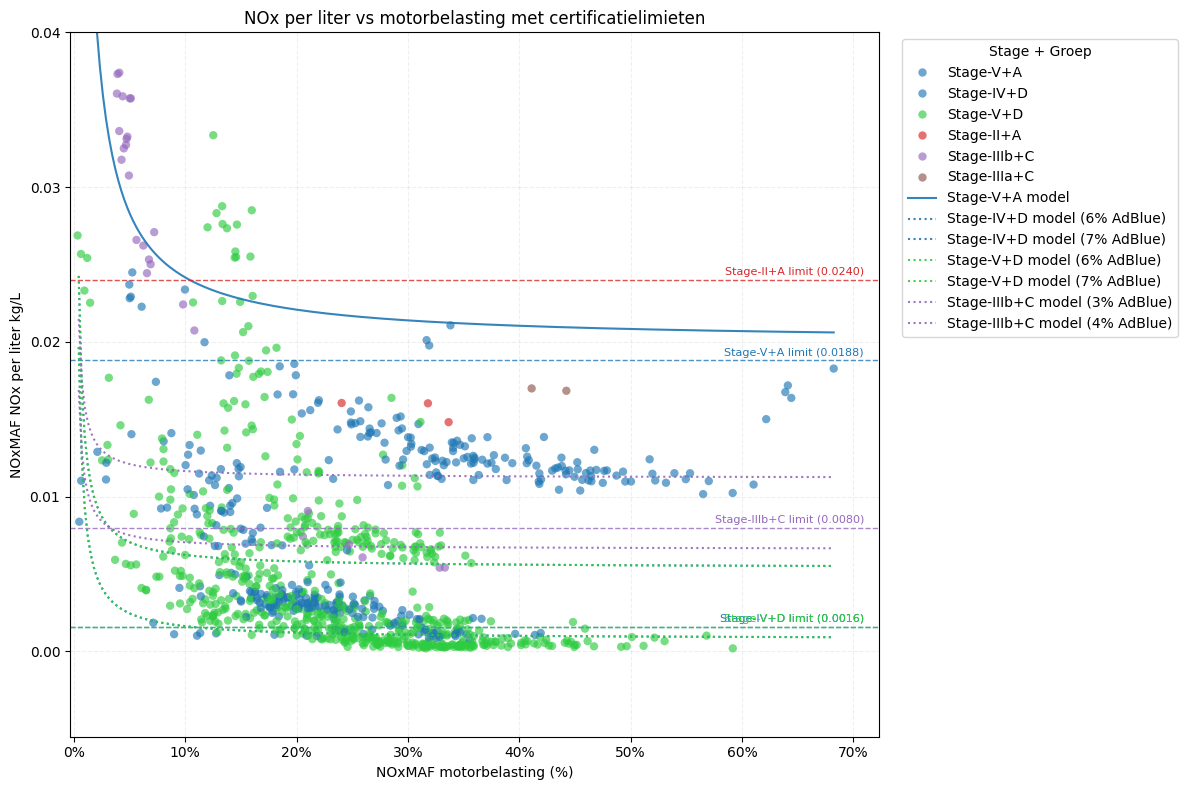

Stage+Groep
Stage-II+A       1
Stage-IIIa+C     1
Stage-IIIb+C     2
Stage-IV+D       7
Stage-V+A        5
Stage-V+D       22
Name: MachineId, dtype: int64


In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Scatter plot preparation: reuse the strict filters from the earlier selection
scatter_exclusions = ['', '+', 'nan+nan']
scatter_df = nox_df[
    (~nox_df["Stage+Groep"].isin(scatter_exclusions))
    & (nox_df["duration_from_rows"] >= 0.5)
    & (nox_df["FuelMassFlow"] >= 0.5)
].copy()
scatter_df = scatter_df.dropna(subset=["NOxMAF_motorbelasting", "NOxMAF_NOxPerLiter", "Stage+Groep"])

# scatter_df = scatter_df[scatter_df["Machinegroep"] == 'D']
# scatter_df = scatter_df[scatter_df["SubgroupLabel"] == 'Hydraulische rupsgraafmachine > 150 kW']

if scatter_df.empty:
    raise ValueError("No rows available for the scatter plot after applying the filters.")

unique_stage_groups = scatter_df["Stage+Groep"].unique()
base_palette = sns.color_palette("tab10", len(unique_stage_groups))
palette = dict(zip(unique_stage_groups, base_palette))
palette_overrides = {
    "Stage-V+D": "#2ecc40",  # bright green
    "Stage-IV+D": "#1f77b4",  # deep blue
}
for label, color in palette_overrides.items():
    if label in palette:
        palette[label] = color
model_handles = []
model_labels = []

fig, ax = plt.subplots(figsize=(12, 8))
sns.scatterplot(
    data=scatter_df,
    x="NOxMAF_motorbelasting",
    y="NOxMAF_NOxPerLiter",
    hue="Stage+Groep",
    palette=palette,
    alpha=0.65,
    edgecolor="none",
    ax=ax,
)

# Horizontal certification limits per Stage+Groep derived from the helper function
x_min = scatter_df["NOxMAF_motorbelasting"].min()
x_max = scatter_df["NOxMAF_motorbelasting"].max()
x_span = max(1e-6, x_max - x_min)
ax.set_xlim(x_min - 0.01 * x_span, x_max + 0.06 * x_span)
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{x*100:.0f}%"))

grid_min = max(1e-3, min(x_max, x_min + 1e-3))
grid_max = max(grid_min + 1e-3, x_max)
motorbelasting_grid = np.linspace(grid_min, grid_max, 250)

for stage_group in unique_stage_groups:
    parts = [part.strip() for part in stage_group.split("+")]
    stage_part = parts[0] if parts else None
    machine_group = parts[1] if len(parts) > 1 else None

    if not stage_part or not machine_group:
        continue

    try:
        limit_value = certification_limit(stage_part, machine_group=machine_group) / 1000
    except ValueError:
        # Skip combinations that cannot be resolved with the helper
        continue

    # Certificatielimiet
    ax.axhline(limit_value, color=palette[stage_group], linestyle="--", linewidth=1, alpha=0.8)
    ax.text(
        x_max + 0.04 * x_span,
        limit_value + 0.0005,
        f"{stage_group} limit ({limit_value:.4f})",
        color=palette[stage_group],
        fontsize=8,
        va="center",
        ha="right",
    )

    # AdBlue model
    group_key = machine_group.strip().upper()
    adblue_samples = [0.0]
    if group_key == "C":
        adblue_samples = [3.0, 4.0]
    elif group_key == "D":
        adblue_samples = [6.0, 7.0]
        

    for pct in adblue_samples:
        try:
            polynomial = nox_per_liter_polynomial(stage_part, machine_group, adblue_pct=pct)
        except ValueError:
            continue

        y_vals = np.array([polynomial(x) for x in motorbelasting_grid])
        linestyle = "-" if pct == 0 else ":"
        label = f"{stage_group} model"
        if len(adblue_samples) > 1:
            label += f" ({pct:.0f}% AdBlue)"

        line, = ax.plot(
            motorbelasting_grid,
            y_vals,
            color=palette[stage_group],
            linestyle=linestyle,
            linewidth=1.5,
            alpha=0.9,
        )
        model_handles.append(line)
        model_labels.append(label)

ax.set_xlabel("NOxMAF motorbelasting (%)")

ax.set_ylabel("NOxMAF NOx per liter kg/L")
ax.set_title("NOx per liter vs motorbelasting met certificatielimieten")
ax.set_ylim(top=0.04)
ax.grid(True, linestyle="--", alpha=0.2)

handles, labels = ax.get_legend_handles_labels()
handles += model_handles
labels += model_labels
ax.legend(handles, labels, title="Stage + Groep", bbox_to_anchor=(1.02, 1), loc="upper left")
fig.tight_layout()
plt.show()

print(scatter_df.groupby('Stage+Groep')['MachineId'].nunique())

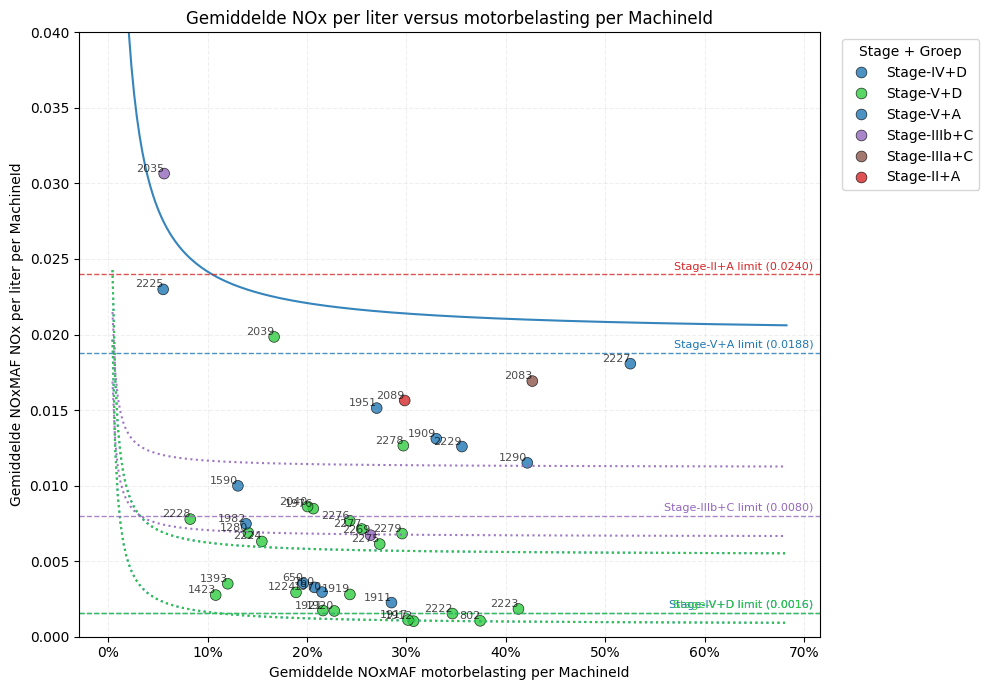

Machines per Stage+Groep (gemiddelden):
stage_group
Stage-II+A       1
Stage-IIIa+C     1
Stage-IIIb+C     2
Stage-IV+D       7
Stage-V+A        5
Stage-V+D       22
Name: MachineId, dtype: int64


In [7]:
# Machine-level average NOx per liter vs motor load
machine_avg_df = (
    scatter_df.groupby("MachineId")
    .agg(
        avg_motorbelasting=("NOxMAF_motorbelasting", "mean"),
        avg_nox_per_liter=("NOxMAF_NOxPerLiter", "mean"),
        stage_group=("Stage+Groep", "first"),
    )
    .dropna()
    .reset_index()
)

if machine_avg_df.empty:
    raise ValueError("No machine-level aggregates available for plotting.")

machine_palette = {
    stage: palette.get(stage, sns.color_palette("tab20", 1)[0])
    for stage in machine_avg_df["stage_group"].unique()
}

fig, ax = plt.subplots(figsize=(10, 7))
sns.scatterplot(
    data=machine_avg_df,
    x="avg_motorbelasting",
    y="avg_nox_per_liter",
    hue="stage_group",
    palette=machine_palette,
    s=60,
    alpha=0.8,
    edgecolor="black",
    linewidth=0.5,
    ax=ax,
)

# Add MachineId labels to each point
for _, row in machine_avg_df.iterrows():
    ax.text(
        row["avg_motorbelasting"],
        row["avg_nox_per_liter"],
        str(row["MachineId"]),
        fontsize=8,
        alpha=0.7,
        ha="right",
        va="bottom"
    )

unique_stage_groups = machine_avg_df["stage_group"].unique()
for stage_group in unique_stage_groups:
    parts = [part.strip() for part in stage_group.split("+")]
    stage_part = parts[0] if parts else None
    machine_group = parts[1] if len(parts) > 1 else None

    if not stage_part or not machine_group:
        continue

    try:
        limit_value = certification_limit(stage_part, machine_group=machine_group) / 1000
    except ValueError:
        # Skip combinations that cannot be resolved with the helper
        continue

    # Certificatielimiet
    ax.axhline(limit_value, color=palette[stage_group], linestyle="--", linewidth=1, alpha=0.8)
    ax.text(
        x_max + 0.04 * x_span,
        limit_value + 0.0005,
        f"{stage_group} limit ({limit_value:.4f})",
        color=palette[stage_group],
        fontsize=8,
        va="center",
        ha="right",
    )

    # AdBlue model
    group_key = machine_group.strip().upper()
    adblue_samples = [0.0]
    if group_key == "C":
        adblue_samples = [3.0, 4.0]
    elif group_key == "D":
        adblue_samples = [6.0, 7.0]
        

    for pct in adblue_samples:
        try:
            polynomial = nox_per_liter_polynomial(stage_part, machine_group, adblue_pct=pct)
        except ValueError:
            continue

        y_vals = np.array([polynomial(x) for x in motorbelasting_grid])
        linestyle = "-" if pct == 0 else ":"
        label = f"{stage_group} model"
        if len(adblue_samples) > 1:
            label += f" ({pct:.0f}% AdBlue)"

        line, = ax.plot(
            motorbelasting_grid,
            y_vals,
            color=palette[stage_group],
            linestyle=linestyle,
            linewidth=1.5,
            alpha=0.9,
        )
        model_handles.append(line)
        model_labels.append(label)


ax.set_xlabel("Gemiddelde NOxMAF motorbelasting per MachineId")
ax.set_ylabel("Gemiddelde NOxMAF NOx per liter per MachineId")
ax.set_ylim(0, 0.04)
ax.set_title("Gemiddelde NOx per liter versus motorbelasting per MachineId")
ax.grid(True, linestyle="--", alpha=0.2)
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{x*100:.0f}%"))
ax.legend(title="Stage + Groep", bbox_to_anchor=(1.02, 1), loc="upper left")
fig.tight_layout()
plt.show()

machine_counts = machine_avg_df.groupby("stage_group")["MachineId"].nunique()
print("Machines per Stage+Groep (gemiddelden):")
print(machine_counts)